# NYC fare prediction using Rapids and XG Boost running on GPU

[This notebook](TBD) shows my approach for predicting the fare amount for a taxi ride in NYC when given the pickup and dropoff locations of the passangers regarding the [New York City Taxi Fare Prediction Challange]( https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).



---

This notebook is seperated into different sections, relating to the common data science workflow (except the hypothesis and data collection where already done). I tested different models to get used to Rapids and Cudf by starting with simple linear models and ended up with XG Boost and Light GBM. The best performant results are deffinitely the XG Boost ones. Different other Kernels state that they achieve similar results with LGBM hence I had problems with running the model on the GPU although I installed the right version (some bug reports also suggest there is a problem with the model).


0.   Previous Commits
1.   Setup and Check Infrastructure
2.   Having a first look at the Data (EDA)
3.   Data Cleaning (Feature Engineering)
4.   Linear Regression GPU
5.   Ridge Regression GPU
6.   K-Nearest Neighbor Regression GPU
7.   Random Forest GPU
8.   XG Boost on GPU
9.   Light GBM on GPU (not running on Colab)
10.   Stacked Ensemble XGB and LGBM
11.   Evaulation

---

## Approach:

I started with this project by getting used to the Rapids environment and the Cuda librarys and went on for more advanced models (XGB and LGBM) with testing them on common parameters mentioned in different notebooks on kaggle (see inspiration in first section) to get a feeling what influences what and how does it generelly work. After gaining some experience I combined several data cleaning approaches from differnt notebooks and general information from the internet. The most promising score yet was 3.19347 which would result in rank 432 of the public leaderboard (if the competition would still run). My kaggle notebook can be found [here, user handle: AlexS2020](https://)


## Evaluation:
As will be mentioned in the last section, I used to compare the different RMSE and R2 score values of different models as well as uploading the submission files to get a direct comperision via the score. Last step to evaluate are the confusion_matrices to see how many false positive/negative and true postivie/negative there are.

## Conclusion:
Overall it was an interesting project / competition which enabled me to learn new stuff and try out several tools. It is interesting to see, that the same code running on the GPU is so much faster compared to CPU implementations when looking at XGB for example. Interesting to me was also that relatively simple models like the KNN or Random Forest performed quite well in relation to the training runtime and ressource consumption. It would have been nice to directly compare the LBGM model against XGB since I read quite a bit about both. Unfortunately this was not possible within the desired scope due to runtime issues mostly. 

Another interesting aspect was to see the huge difference a properly cleaned dataset can make when using the same model.


## Outlook:
There are several ways how to improve these scores from my point of view. Some of them can be seen in other notebooks already (especially the larger ones).

1.   Run the code on several GPUs to figure out how well Rapids really performs in combination with DASK compared to one GPU or CPU.
2.   Ensemble different models based on their R2 score to test if the gap can be reduced this way (depending on the strength of the used models) An initial implementation for this is given in section 10. but I could not test it yet,
3.   Use larger grid searches to find better parameters for the given models
4.   An adaptive learning rate could also help with optimizing the results

## Limitations:
- It was possible to install the LBGM Version for GPU and the memory was consumed by the data but it did not run on the GPU somehow. So it was quite slow to do some training on this model and I could not compare it directly to XGB (or combine these two as intended in section 10)
- Some of the points mentioned in Outlook were not possible since running code in browser + only 36h GPU-time per week is hardly enough
- Automation of parameter search on large scale not feasible (not even with the GPU)


##References:
Inspirations for implementation and design:

- https://github.com/rapidsai/cuml/tree/branch-0.13/notebooks 
- https://www.kaggle.com/beniel/rapids-cudf-tutorial
- https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging
- https://www.kaggle.com/confirm/xfeat-cudf-lightgbm-catboost-wip
- https://www.kaggle.com/aiswaryaramachandran/baseline-model-xgboost-3-03-rmse/data?select=train_cleaned.csv
- https://www.kaggle.com/aiswaryaramachandran/eda-and-feature-engineering/comments
- https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
- https://www.kaggle.com/pnprabakaran/ny-city-taxi-fare-exploration-with-dask-and-dxgb
- https://www.kaggle.com/dsaichand3/lgbm-gpu
- https://www.kaggle.com/amar09/fare-prediction-stacked-ensemble-xgboost-lgbm/log
- https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

Thanks to anyone whos code I have used!




# 0. Previous Commits - Comparison of different Models and Scores



Predictions are done when using the whole data set

### Linear Regression

**Commit 30 (Baseline) Score: 5.15497**
  - R2 score = 0.7166260480880737

### Ridge Regression

**Commit 31 Score: 5.15489**

params_ridge
  - alpha = loguniform(1e-5, 1e0)
  - solver = ['eig', 'cd']
  - n_iter = 100
  - cv = 5
  - verbose = 0
  - n_jobs = 1

ridge_params
  - alpha = 0.240960447726532
  - fit_intercept = True
  - normalize = False
  - solver = 'eig'

  - R2 score = 0.7166244983673096

### K-Nearest Neighbor 
**Commit 33 Score: 4.67805**
  - n_neighbors = 4
  - data_size = 55 Mio rows
  - R2 score = 0.7047221660614014

### Random Forest 
**Commit 34 Score: 3.96958**
  - n_estimators=10
  - n_jobs=-1
  - data_size = 55 Mio rows
  - R2 score = 0.6802817583084106

### XG Boost (GPU)
**Commit 5 Score: 3.98546**
  - n_estimators':500,
  - max_depth':7,
  - learning_rate':0.0005,
  - subsample':0.9,
  - colsample_bytree':0.9,
  - missing':-999,
  - random_state':2020,
  - objective':'reg:linear',
  - gamma':0.3,
  - reg_alpha':0.01,
  - tree_method':'gpu_hist'

  - data_size = 7 Mio. rows

### XG Boost (GPU) BEST
**Commit 23 Score: 3.19116**
  - n_estimators':350,
  - max_depth':7,
  - learning_rate':0.003,
  - subsample':0.9,
  - colsample_bytree':0.9,
  - missing':-999,
  - random_state':2020,
  - objective':'reg:linear',
  - gamma':0.3,
  - reg_alpha':0.01,
  - tree_method':'gpu_hist'  

  - rounds = 80000
  - early stopping = 250
  - R2 score = 0.832559
  - Test-rmse = 3.64371
  - Wall time = 49 min
  - data_size = 55 Mio. rows, cleaned dataset

# 1. Setup and Check Infrastructure
The first step is to get the infrastructure up and running. Important to mention here is that it is strongly recommended to use a GPU for calculation purpose.


If you find yourself running these notebooks on Colab as well as on Kaggle you might find this placeholder thing helpful. Only thing to touch is the environment you are running on (Kaggle or Colab).

Optional parameters:
- cleaned_dataset when you are running on Kaggle an use a precleaned one
- debug_mode for enabling a minimal row number
- rows_datasample defining how many rows will be used in the training (irrelevant when debug_mode=True)

In [2]:
## Switch from Kaggle to Colab easily
environment='Colab' ## Kaggle / Colab

## Using Cleaned dataset? This can be useful when running into crashes or Cudf incompatibility, just add this to the kaggle input: https://www.kaggle.com/aiswaryaramachandran/baseline-model-xgboost-3-03-rmse/data?select=train_cleaned.csv
cleaned_dataset=True ## Change to True or False

## when True only 50.000 rows are used for debugging purpose. Set to False when doing real training
debug_mode=True ## Change to True or False

## choose how many rows of the training data sample you would like to use (only works when debug_mode=False ), max is 55423480
rows_datasample=5542348

### Installing all necessary librarys and tools

Setting up the environment path accordingly to your choice of environment

In [3]:
if environment == 'Kaggle':
  env_submission_path='./'
  env_path='../input/new-york-city-taxi-fare-prediction/'
  print('The environment and paths were successfully setup for Kaggle')
elif environment == 'Colab':
  env_submission_path='/content/drive/My Drive/Colab Notebooks/'
  env_path='/content/drive/My Drive/Colab Notebooks/'

  from google.colab import drive
  drive.mount('/content/drive')

  print('The environment and paths were successfully setup for Colab')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing)')


Mounted at /content/drive
The environment and paths were successfully setup for Colab


Check for GPU

In [4]:
!nvidia-smi

Wed Sep 30 14:09:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!lscpu | grep "Model name:"
!lscpu | grep "CPU(s)"

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
CPU(s):              2
On-line CPU(s) list: 0,1
NUMA node0 CPU(s):   0,1


Depending on the environment you might want to install different packages (or just link to them)

In [6]:
%%time
if environment == 'Kaggle':
  import sys
  !cp ../input/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
  !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
  !cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/
  print('You are all set for the kaggle rapids environment')

elif environment == 'Colab':
  # Install RAPIDS and Dask_ml
  !pip install dask_ml
  !pip install dask_cuda
  !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
  !bash rapidsai-csp-utils/colab/rapids-colab.sh stable

  import sys, os
  dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
  sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
  sys.path
  exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
  print('You are all set for the colab rapids environment')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing). If Kaggle failed please make sure you added the RAPIDS file on Kaggle to your Input!')

     |████████████████████████████████| 143kB 4.6MB/s 
     |████████████████████████████████| 6.8MB 9.5MB/s 
     |████████████████████████████████| 655kB 48.1MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=e1b694c5280aff164bf7c1407a3677fbb8f386cc47fd3a7eacd30c5859b954c0
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=f5956dc58aede7f4b78764c881b7cc4dbb9a14e0629a24d5a5502963cf447182
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2.28.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: scikit-learn 

Library import, important to notice here is we are using mostly cuml librarys for GPU access

In [7]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp
import pandas as pd

import time 
import itertools

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models https://github.com/rapidsai/cuml/tree/branch-0.13/notebooks
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF # RandomForest

from cuml.neighbors import KNeighborsRegressor as cumlKNR # Nearest Neighbours
from cuml.svm import SVC # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.


When running XG Boost distributed on several GPUs you need to install Dask_xgboost. Did this for some benchmarking, although it did not run on one GPU. You can spare this installation if you only have one GPU.

In [8]:
#!pip install -U xgboost
!pip install dask-xgboost
import dask_xgboost as dxgb

import dask; print('Dask Version:', dask.__version__)

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

# create a local cluster with 4 workers
n_workers = 1
# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client

from dask.delayed import delayed

import dask.dataframe as dd
import dask.array as da

import cudf; print('cuDF Version:', cudf.__version__)
import numpy as np; print('NumPy Version:', np.__version__)

     |████████████████████████████████| 142.8 MB 50 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.1.0
    Uninstalling xgboost-1.1.0:
      Successfully uninstalled xgboost-1.1.0
Dask Version: 2.28.0
cuDF Version: 0.14.0
NumPy Version: 1.18.5


/usr/local/lib/python3.6/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.1  |
| tornado | 5.1.1  | 5.1.1     | 6.0.4   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


### Helper Functions

Since the save to CSV file and the calculation of the R2 score show up quite often during this kernel I decided to place them in small functions for an easy and reusable approach.

In [9]:
def save_model_csv(y_pred, csv_name):
  save_submission = submission
  save_submission['fare_amount']=y_pred
  save_submission.to_csv(env_submission_path+csv_name, index=False)
  return save_submission.head(2)

In [10]:
def calc_R2(y_pred, model_name):
  score = r2_score(y_pred, y_test)
  print("R2 Score for the "+model_name+" model is: ",score)
  return score

In [ ]:
## initializing the r2 scores so there will be no errors at the end when comparing them even if we do not run all models
score_linear_reg=0
score_ridge_reg=0
score_KNN=0
score_Rand_For=0
score_XGB_GPU=0
score_LGBM=0

# 2. First look at the Data (EDA)

The inital step to getting used to the data is having a look at it and loading it in a useable structure.

Before we can train something which predicts the taxi fares we first have to take a look what data we have available. We start by loading the data into cudf dataframes by selecting the relevant columns first. 

---
It happens that the system crashes if you choose a row number which is too large so that the data overflows your RAM / GPU (especially on colab, max 5 Mio rows). On Kaggle you can go up to max. 41 Mio. rows. If you choose to use the precleaned dataset you can use all the available data.

In [98]:
cudf.set_allocator("managed")

## Check if using cleaned dataset or not
if cleaned_dataset==False:
    dtype = {     
        'key':'str',
        'fare_amount': 'float32',
        'pickup_datetime':'str',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'int8'}
else:
    dtype = {     
        'key':'str',
        'fare_amount': 'float32',
        'pickup_datetime':'str',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'int8',
        'pickup_latitude_round3': 'float32',
        'pickup_longitude_round3': 'float32',
        'dropoff_latitude_round3': 'float32',
        'dropoff_longitude_round3': 'float32',
        'is_pickup_JFK': 'int8',
        'is_dropoff_JFK': 'int8',
        'is_pickup_EWR': 'int8',
        'is_dropoff_EWR': 'int8',
        'is_pickup_la_guardia': 'int8',
        'is_dropoff_la_guardia': 'int8',
        'is_pickup_lower_manhattan': 'int8',
        'is_dropoff_lower_manhattan': 'int8'
    }

usecols = list(dtype.keys())

Load the data using cudf. Path variables are adjusted accordingly 

In [99]:
%%time
# use a subset with 50.000 rows, max is nrows = 55423480

if debug_mode == True:
  ## using 1% (or how much you like)
  nrows = 50000
    
#del X_train, X_test, y_train, y_test
#gc.collect()

## Check if using cleaned dataset or not and adjusting the links accordingly
if cleaned_dataset==False:
    test = cudf.read_csv(env_path+'test.csv', usecols=usecols, dtype=dtype)
    train = cudf.read_csv(env_path+'train.csv', nrows=nrows, usecols=usecols, dtype=dtype)
else:
    nrows=55000000
    test = cudf.read_csv('../input/eda-and-feature-engineering/test_cleaned.csv', usecols=usecols, dtype=dtype)
    train = cudf.read_csv('../input/eda-and-feature-engineering/train_cleaned.csv', nrows=nrows, usecols=usecols, dtype=dtype)
    
submission = cudf.read_csv(env_path+'sample_submission.csv', usecols=usecols, dtype=dtype)

CPU times: user 311 ms, sys: 421 ms, total: 732 ms
Wall time: 1.26 s


In [100]:
train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [101]:
test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739197,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982536,40.751259,-73.979668,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981163,40.767811,-73.990440,40.751633,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966042,40.789776,-73.988579,40.744431,1


# 3. Data Cleaning

Before being able to start with the predictions, the data should be cleaned up and extended/enriched by relevant columns to achieve better results. For this, we are splitting the key (date & time) into seperate columns and add new features like the driven distance. This approch showed the best results so far. There are some limitations given that cudf and pandas are partly incompatible so I decided to test it out with a precleaned dataset as well to see the improvements later.

In [102]:
#Drop Nan Values
train.nans_to_nulls()
train = train.dropna()

In [103]:
#Checking shape of the data
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (4999964, 8)
Test: (9914, 7)


Not available in Cudf datetime which could have improved results:
- Dayofyear, Weekofyear, Weekday, Quarter, day of month

In [104]:
#Changing the data format of pickup_datetime and adding additional information about pickup time
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64[ns]')

train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year


test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64[ns]')

test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

Adding distances to airports does not work using cudf due to data type error (Series, Float) although the normal distance function (as below) works well. Tried different converting approaches including .astype(...) as you can see below at one example.

In [105]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - 40.7141667) + np.abs(dropoff_long - -74.0063889) ## not even working when putting the coordinates right in
    return distance

#calculate trip distance in miles
def calc_distance(data):

    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(40.7141667, -74.0063889, data['pickup_latitude'].astype(float, copy=False, errors='ignore'), data['pickup_longitude'].astype(float, copy=False, errors='ignore'))
    #data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0], data['pickup_latitude'], data['pickup_longitude'])
    #data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0], data['dropoff_latitude'], data['dropoff_longitude'])
    #data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0],  data['pickup_latitude'], data['pickup_longitude'])
    #data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0], data['dropoff_latitude'], data['dropoff_longitude'])
    #data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],  data['pickup_latitude'], data['pickup_longitude'])
    #data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0], data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

#calc_distance(train)
#train.head(2)

In [106]:
#calculate trip distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [107]:
train['distance'] = distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'] )
test['distance'] = distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'] )
train['distance'].describe()

count    4.999964e+06
mean     1.214851e+01
std      2.308634e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.367415e+00
max      1.187364e+04
Name: distance, dtype: float64

In [108]:
#check if everything worked
train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982742,40.761269,-73.991234,40.750565,2,0,3,8,2011,0.000000
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987137,40.733139,-73.991570,40.758095,1,4,5,4,2012,1.932986
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968102,40.768009,-73.956665,40.783768,1,7,1,3,2010,1.366828
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45,-74.000969,40.731628,-73.972893,40.758232,1,9,3,1,2011,2.425102
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00,-73.980003,40.751663,-73.973801,40.764847,1,20,1,11,2012,0.000000
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00,-73.951302,40.774139,-73.990097,40.751045,1,17,2,1,2012,2.480990
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006454,40.726719,-73.993073,40.731625,1,13,0,12,2012,0.000000
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00,-73.980667,40.733871,-73.991539,40.758137,2,1,2,9,2009,1.932986


In [109]:
test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.366828
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739197,1,13,1,1,2015,1.366828


In [110]:
print("Ararage fare amount: " + str(train['fare_amount'].mean()))
print("Standard deviation fare amount: " + str(train['fare_amount'].std()))
print("Ararage distance: " + str(train['distance'].mean()) + " miles")
print("Standard deviation distance: " + str(train['distance'].std()) + " miles")

Ararage fare amount: 11.340743534360291
Standard deviation fare amount: 9.820065758732818
Ararage distance: 12.148504865121742 miles
Standard deviation distance: 230.86339215143522 miles


In [111]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
count,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06
mean,1.134074e+01,-7.250681e+01,3.991976e+01,-7.250652e+01,3.991725e+01,1.684297e+00,1.351062e+01,3.041885e+00,6.266933e+00,2.011739e+03,1.214851e+01
std,9.820066e+00,1.280962e+01,8.963488e+00,1.284777e+01,9.486767e+00,1.310633e+00,6.516342e+00,1.949259e+00,3.435217e+00,1.860233e+00,2.308634e+02
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,-1.270000e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03,0.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03,1.366828e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03,2.367415e+00
max,1.273310e+03,3.439425e+03,3.310365e+03,3.457622e+03,3.345917e+03,5.100000e+01,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03,1.187364e+04


Visualization of the data <br>

The following things were noticed (while using 500k datapoints):
*   The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
*   Some of the minimum and maximum longitude/lattitude coordinates are way off. These  will also be remove from the dataset. (bounding box will be defined)
*   The average fare_amount is about 9.79 USD with a standard deviation of 7.48 USD. When building a predictive model we want to be better than 7.48 USD.



In [112]:
train = train[train.fare_amount>=0]
train = train[(train['distance'] < 30) & (train['distance'] >=0 )]

In [113]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
distance = train['distance'].to_array()

Text(0.5, 1.0, 'Verteilung des Fahrpreises')

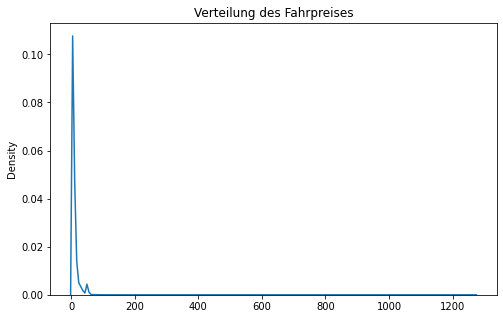

In [114]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

Text(0.5, 1.0, 'Distanz')

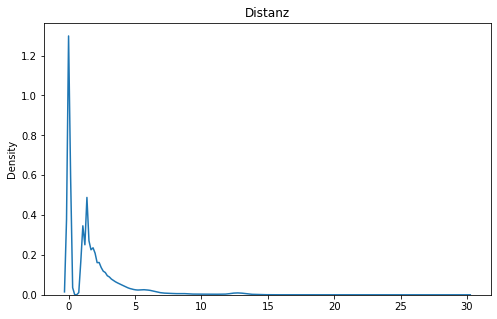

In [115]:
plt.figure(figsize=(8,5))
sns.kdeplot(distance).set_title("Distanz")

In [116]:
#check max latitude und max longitude of test data
print("Max lat pickup: " + str(test['pickup_latitude'].max()))
print("Max lat dropoff: " + str(test['dropoff_latitude'].max()))
print("Max lon pickup: " + str(test['pickup_longitude'].max()))
print("Max lon dropoff: " + str(test['dropoff_longitude'].max()))
print("")
print("Min lat pickup: " + str(test['pickup_latitude'].min()))
print("Min lat dropoff: " + str(test['dropoff_latitude'].min()))
print("Min lon pickup: " + str(test['pickup_longitude'].min()))
print("Min lon dropoff: " + str(test['dropoff_longitude'].min()))

Max lat pickup: 41.709553
Max lat dropoff: 41.696682
Max lon pickup: -72.986534
Max lon dropoff: -72.99096

Min lat pickup: 40.57314
Min lat dropoff: 40.568974
Min lon pickup: -74.25219
Min lon dropoff: -74.26323


Bounding Box New York
<table>
  <tr>
    <th></th>
    <th>Dropoff</th>
    <th>Pickup</th>
  </tr>
  <tr>
    <td>Max Long</td>
    <td>-72.99096</td>
    <td>-72.986534</td>
   </tr>
   <tr>
    <td>Max Lat</td>
    <td>41.696682</td>
    <td>41.709553</td>
   </tr>
   <tr>
    <td>Min Long</td>
    <td>-74.26323</td>
    <td>-74.25219</td>
    </tr>
   <tr>
    <td>Min Lat</td>
    <td>40.568974</td>
    <td>40.57314</td>
   </tr>
</table>



In [117]:
train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [118]:
#Parts of train data are too far away, so they can be dropped
train = train[(train['pickup_longitude'] > -74.25) & (train['pickup_longitude'] < -72.98)]
train = train[(train['pickup_latitude'] > 40.57) & (train['pickup_latitude'] < 41.70)]
train = train[(train['dropoff_longitude'] < -72.99) & (train['dropoff_longitude'] > -74.26)]
train = train[(train['dropoff_latitude'] > 40.56) & (train['dropoff_latitude'] < 41.69)]

(-74.03, -73.75)

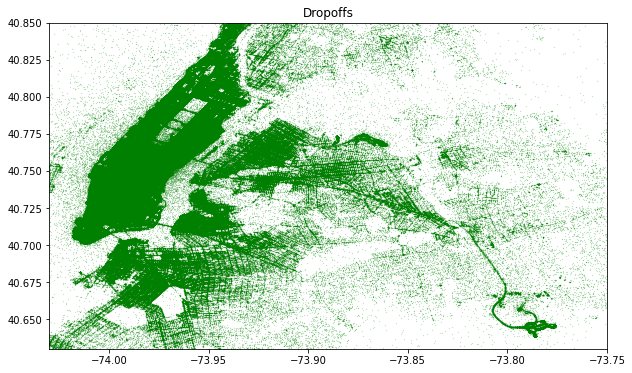

In [119]:
dropoff_longitude = train['dropoff_longitude'].to_array()
dropoff_latitude = train['dropoff_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Tested different columns to see which have the most impact. Pickup_datetime seems to be irrelevant for the predictions so dropping it together with key.

In [120]:
## Kicking out unrelevant columns
unnecessary_columns=['key','pickup_datetime']
train=train.drop(unnecessary_columns,axis=1)
test=test.drop(unnecessary_columns,axis=1)

In [121]:
train.head(2)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,passenger_count,hour,weekday,month,year,distance
0,2009-06-15 17:26:21.0000001,4.5,-73.844307,40.721321,-73.841614,1,17,0,6,2009,0.000000
1,2010-01-05 16:52:16.0000002,16.9,-74.016045,40.711304,-73.979271,1,16,1,1,2010,5.244397


In [122]:
test.head(2)

,key,pickup_longitude,pickup_latitude,dropoff_longitude,passenger_count,hour,weekday,month,year,distance
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,1,13,1,1,2015,1.366828
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,1,13,1,1,2015,1.366828


Splitting the train data here

In [124]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

## getting the columns into the same order since XGB and LGBM seems to have a problem if they are not aligned
test = test[train.columns.drop(['fare_amount'])]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## free some storage by cleaning up the previous unneeded variables
del X, y
gc.collect()

Number of records in training data  3913464
Number of records in validation data  978366
(3913464, 10)
(978366, 10)
(3913464,)
(978366,)


2469

# 4. Linear Regression
This counts as our baseline model and showcases the most simple model here.

In [ ]:
lm = LinearRegression(fit_intercept = True, 
                      normalize = False,
                      algorithm = "eig")
lm.fit(X_train,y_train)

LinearRegression(algorithm='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f82c6967650>, verbose=2, output_type='cudf')

In [ ]:
y_test_pred=lm.predict(X_test)
score_linear_reg = calc_R2(y_test_pred, 'Linear Regression')

RMSE for the Linear Regression model is:  0.6146653890609741


In [ ]:
y_pred_LR=lm.predict(test)

save_model_csv(y_pred_LR, 'submission_LinearReg')

,fare_amount
0,11.064941
1,11.064941


# 5. Ridge Regression

This model is a little buggy and fails every second time to load. The results compared to the linear regression are not really an improvement here with R2 values and submission score being pretty much identical and still having longer training time.

In [ ]:
params_ridge = {
    "alpha": loguniform(1e-5, 1e0), # default 1.0
    "solver": ['eig', 'cd'], 
}
ridge = Ridge()
clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

RuntimeError: ignored

In [ ]:
best_model.best_estimator_.get_params()

In [ ]:
ridge_params = {
 'alpha': 0.240960447726532,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'
}

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

In [ ]:
y_test_pred = result_ridge.predict(X_test)
score_ridge_reg =calc_R2(y_test_pred, 'Ridge Regression')

In [ ]:
y_pred_RR = result_ridge.predict(test)
save_model_csv(y_pred_RR, 'submission_RidgeReg')

# 6. K-Nearest Neighbors Regression



https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/kneighbors_regressor_demo.ipynb



In [ ]:
## params
n_neighbors=4

inspiration: https://www.kaggle.com/cdeotte/rapids-knn-30-seconds-0-938/notebook

In [ ]:
%%time
knn_cuml = cumlKNR(n_neighbors=n_neighbors)
knn_cuml.fit(X_train, y_train)

CPU times: user 2.08 ms, sys: 1.99 ms, total: 4.06 ms
Wall time: 4.16 ms


In [ ]:
y_test_pred = knn_cuml.predict(X_test)
score_KNN = calc_R2(y_test_pred, 'K-nearest Neigbors Regression')

RMSE for the K-nearest Neigbors Regression model is:  0.5835455060005188


In [ ]:
y_pred_KNN = knn_cuml.predict(test)

save_model_csv(y_pred_KNN, 'submission_KNN')

,fare_amount
0,10.0
1,10.0


# 7. Random Forest GPU


In [ ]:
## params
n_estimators=10
n_jobs=-1

In [ ]:
%%time
rf_cuml = cuRF(n_estimators=n_estimators)
rf_cuml.fit(X_train, y_train)

CPU times: user 114 ms, sys: 95.6 ms, total: 210 ms
Wall time: 140 ms


In [ ]:
y_test_pred = rf_cuml.predict(X_test)
score_Rand_For =calc_R2(y_test_pred, 'Random Forest')

RMSE for the Random Forest model is:  0.2536487579345703


In [ ]:
y_pred_RF = rf_cuml.predict(test)
save_model_csv(y_pred_RF, 'submission_RandomForest')

,fare_amount
0,9.172441
1,9.172441


# 8. XG Boost

In [ ]:
params_gpu = {
    'n_estimators':350,  
    'max_depth':7,    
    'learning_rate':0.003, 
    'subsample':0.9,    
    'colsample_bytree':0.9,    
    'missing':-999,    
    'random_state':2020,    
    'objective':'reg:linear',    
    'gamma':0.3,    
    'reg_alpha':0.01,    
    'tree_method':'gpu_hist'  # THE MAGICAL PARAMETER
}

## if you would like to compare runtime on CPU choose this one:
params_cpu = {
    'n_estimators':500,
    'max_depth':7,
    'learning_rate':0.0005,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'missing':-999,
    'random_state':2020,
    'objective':'reg:linear',
    'gamma':0.3,
    'reg_alpha':0.01,
}

## XG Boost model GPU

In [ ]:
start_time=time.time()
timetaken_gpu_xgb=time.time()-start_time
timetaken_gpu_xgb

4.172325134277344e-05

Running nicely in Kaggle but not in Colab
- TypeError: can not initialize DMatrix from DataFrame

In [ ]:
%%time
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params_gpu,
                    dtrain=matrix_train,num_boost_round=1000, 
                    early_stopping_rounds=100,evals=[(matrix_test,'test')])
    return model

XGB_model = XGBmodel(X_train,X_test,y_train,y_test,params)

TypeError: ignored

- https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.to_delayed

- https://github.com/dask/dask-ml/issues/521

In [ ]:
timetaken_gpu=time.time()-starttime
print("GPU time taken for XG Boost model: ",timetaken_gpu_xgb)

In [ ]:
y_test_pred = XGB_model.predict(xgb.DMatrix(X_test))
score_XGB_GPU = calc_R2(y_test_pred, 'XGBoost GPU')

y_test_pred_xgb = y_test_pred

In [ ]:
y_pred_XGB = XGB_model.predict(xgb.DMatrix(test), ntree_limit = XGB_model.best_ntree_limit).tolist()

save_model_csv(y_pred_XGB, 'submission_XGboost_GPU')

## XG Boost Dask model for distributed clients (Not running with one client)

- https://www.kaggle.com/sandeepkumar121995/eda-data-cleaning-xg-boost
- https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares
- https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost
- https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s



Running into several problems with XG Boost. Python Kernel stops witout error message 	
- what(): parallel_for failed: cudaErrorNoKernelImageForDevice: no kernel image is available for execution on the device
- https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/13308
- https://github.com/CannyLab/tsne-cuda/issues/18

Hypothesis: There could be an error when loading a cudf dataset in XGBoost. Seems to not happen when using pandas

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  39130
Number of records in validation data  9782
(39130, 6)
(9782, 6)
(39130,)
(9782,)


In [ ]:
y_train['fare_amount']

TypingError: ignored

Error when using evals, turning it off results in Value Error. Not possible to convert matrix_test to something running, tested with pandas df, cudf, numpy. NaN cleanup again, still...
- https://github.com/dmlc/xgboost/issues/2274
- https://github.com/rapidsai/cudf/issues/2892

In [ ]:
%%time
def dask_XGBmodel(X_train,X_test,y_train,y_test,params):
    #matrix_test = xgb.DMatrix(data=dd.from_pandas(X_test.to_pandas(),1), label=dd.from_pandas(y_test.to_pandas(), 1))

    #Drop Nan Values
    X_test.nans_to_nulls()
    X_test = X_test.dropna()

    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model = dxgb.train(client, params=params, 
                       data=dd.from_pandas(X_train, 1), 
                       labels=dd.from_pandas(y_train, 1), 
                       num_boost_round=5000,
                       early_stopping_rounds=10,
                       evals=[(matrix_test,'test')]
                      )
    return model

dask_XGB_model = dask_XGBmodel(X_train,X_test,y_train,y_test,params)

#y_pred = dask_XGB_model.predict(testDGX)

ValueError: ignored

# 9. LGBM model (only runs on Kaggle)

- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

- https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

- https://www.kaggle.com/dsaichand3/lgbm-gpu

- https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging


Compared CPU vs GPU:
- https://www.kaggle.com/ishivinal/sklearn-rapids-pandas


## Setup LGBM with GPU Support (only working on Kaggle, not Colab)

How to setup LGBM GPU Beta:
- https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm


In [125]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

rm: cannot remove '/opt/conda/lib/python3.6/site-packages/lightgbm': No such file or directory
Cloning into 'LightGBM'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19759 (delta 4), reused 0 (delta 0), pack-reused 19740
Receiving objects: 100% (19759/19759), 15.74 MiB | 30.24 MiB/s, done.
Resolving deltas: 100% (14390/14390), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.50 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [126]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

rm: cannot remove 'build': No such file or directory
CMakeFiles/lightgbm.dir/src/treelearner/gpu_tree_learner.cpp.o: In function `boost::compute::detail::program_binary_path(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, bool)':
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x1e5): undefined reference to `boost::filesystem::detail::status(boost::filesystem::path const&, boost::system::error_code*)'
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x233): undefined reference to `boost::filesystem::detail::create_directories(boost::filesystem::path const&, boost::system::error_code*)

In [127]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lig

In [131]:
%%bash
cd ..

In [136]:
#!pip install lightgbm --install-option=--gpu --force-reinstall

/usr/local/lib/python3.6/site-packages/pip/_internal/commands/install.py:235: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 711 kB 4.4 MB/s 
     |████████████████████████████████| 7.3 MB 11.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 25.4 MB 97 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.2 MB 55.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |█████████████████████

In [137]:
import lightgbm as lgbm

OSError: ignored

In [ ]:
## Inspiration from https://www.kaggle.com/dsaichand3/lgbm-gpu
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.15,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 15,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [ ]:
col_cat = X_train.select_dtypes('object').columns.tolist()

d_train = lgbm.Dataset(X_train.to_pandas(), label = y_train.to_pandas(), categorical_feature = col_cat, free_raw_data=False)
d_valid = lgbm.Dataset(X_test.to_pandas(), label = y_test.to_pandas(), categorical_feature = col_cat, free_raw_data=False)

Strange thing is, "GPU Memory consumption" is almost at limit with 41 Mio rows (15.1 GB, max. 15.9 GB) but "Cumulative GPU usage" still shows 0.00 %".

In [ ]:
%%time
model = lgbm.train(params_1, train_set = d_train, num_boost_round=10000, early_stopping_rounds=100, verbose_eval=10, valid_sets=d_valid)

In [ ]:
y_test_pred = model.predict(X_test, num_iteration = model.best_iteration)

score_LGBM = calc_R2(y_test_pred, 'LGBM GPU')

y_test_pred_lgbm = y_test_pred

In [ ]:
y_pred_LGBM = model.predict(test, num_iteration = model.best_iteration)

save_model_csv(y_pred_LGBM, 'submission_LGBM_GPU')

# 10. Stacked Ensemble XGB and LGBM

In my approach to further improve the predictions I tried to combine the two most advanced models as suggested by https://www.kaggle.com/amar09/fare-prediction-stacked-ensemble-xgboost-lgbm/log.

In [ ]:
## ensembled prediction over splitted test data, 50 / 50 split between XGB and LGBM
ensembled_prediction = (0.5*np.expm1(y_test_pred_xgb))+(0.5*np.expm1(y_test_pred_lgbm))

score_LGBM_XGB = =calc_R2(ensembled_prediction, 'LGBM XGB ensemble')

In [ ]:
## submitting the combined prediction, weighted 50 / 50
ensembled_prediction = (0.5*y_pred_XGB)+(0.5*y_pred_LGBM)

save_model_csv(ensembled_prediction, 'submission_ensemble.csv')

# 11. Evaluation

Show R2 Scores of the different models, makes it more convenient to compare in one graph.


In [ ]:
r2_score=[
    score_linear_reg,
    score_ridge_reg,
    score_KNN,
    score_Rand_For,
    score_XGB_GPU,
    score_LGBM,
    #score_LGBM_XGB
]

col={'R2 score':r2_score}
models=[
    'Linear Regression',
    'Ridge Regression',
    'KNN',
    'Random Forest',
    'XGB',
    'LGBM',
    #'LGBM & XGB'
]
df=pd.DataFrame(data=col,index=models)
df

df.plot(kind='bar')